Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\kally\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:06:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.7199488802100332, 'gamma': 0.1482241298580118, 'learning_rate': 0.11914989150418326, 'max_depth': 6, 'n_estimators': 142, 'reg_alpha': 0.06988618831314475, 'reg_lambda': 1.2952673118598903, 'subsample': 0.7604881960143233}
Accuracy: 0.9930947897049592
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1589
           1       0.99      0.99      0.99      1597

    accuracy                           0.99      3186
   macro avg       0.99      0.99      0.99      3186
weighted avg       0.99      0.99      0.99      3186



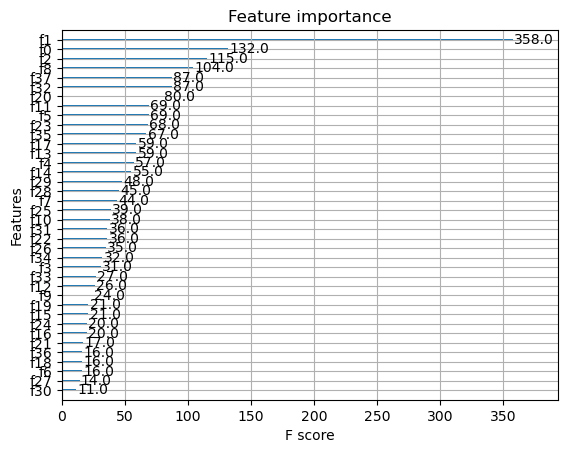

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# 파일 경로
non_flood_data_path = '침수가아닌날데이터.csv'
flood_data_path = '침수학습데이터.csv'

# CSV 파일 불러오기
non_flood_data = pd.read_csv(non_flood_data_path)
flood_data = pd.read_csv(flood_data_path)

# 데이터에 타겟 변수 추가 (침수 여부: 0 - 침수가 아닌 날, 1 - 침수된 날)
non_flood_data['target'] = 0
flood_data['target'] = 1

# 두 데이터를 합침
combined_data = pd.concat([non_flood_data, flood_data], ignore_index=True)

# 사용할 칼럼만 선택
selected_columns = [
    '배수정보', '침수된 지역의 평균 지형 고도', '1시간 누적 강수량(mm)', '1시간 10분 평균 강수량(mm)', '1시간 시간당 강수량(mm)',
    '2시간 누적 강수량(mm)', '2시간 10분 평균 강수량(mm)', '2시간 시간당 강수량(mm)', '3시간 누적 강수량(mm)', '3시간 10분 평균 강수량(mm)',
    '3시간 시간당 강수량(mm)', '4시간 누적 강수량(mm)', '4시간 10분 평균 강수량(mm)', '4시간 시간당 강수량(mm)', '5시간 누적 강수량(mm)',
    '5시간 10분 평균 강수량(mm)', '5시간 시간당 강수량(mm)', '6시간 누적 강수량(mm)', '6시간 10분 평균 강수량(mm)', '6시간 시간당 강수량(mm)',
    '7시간 누적 강수량(mm)', '7시간 10분 평균 강수량(mm)', '7시간 시간당 강수량(mm)', '8시간 누적 강수량(mm)', '8시간 10분 평균 강수량(mm)',
    '8시간 시간당 강수량(mm)', '9시간 누적 강수량(mm)', '9시간 10분 평균 강수량(mm)', '9시간 시간당 강수량(mm)', '10시간 누적 강수량(mm)',
    '10시간 10분 평균 강수량(mm)', '10시간 시간당 강수량(mm)', '11시간 누적 강수량(mm)', '11시간 10분 평균 강수량(mm)', '11시간 시간당 강수량(mm)',
    '12시간 누적 강수량(mm)', '12시간 10분 평균 강수량(mm)', '12시간 시간당 강수량(mm)'
]

# 선택한 칼럼만 사용하여 데이터 준비
X = combined_data[selected_columns]
y = combined_data['target']

# 데이터 스케일링 (XGBoost는 스케일링이 필수는 아니지만, 다른 모델과 함께 사용할 경우 유용함)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터로 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost 모델 설정
xgb_model = xgb.XGBClassifier(use_label_encoder=False)

# 하이퍼파라미터 범위 설정 (RandomizedSearchCV용)
param_distributions = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.19),  # 0.01 ~ 0.2 사이의 랜덤 값
    'max_depth': randint(3, 7),
    'subsample': uniform(0.7, 0.3),  # 0.7 ~ 1.0 사이의 랜덤 값
    'colsample_bytree': uniform(0.7, 0.3),  # 0.7 ~ 1.0 사이의 랜덤 값
    'gamma': uniform(0, 0.2),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0.5, 1.0)
}

# RandomizedSearchCV 설정
random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_distributions, n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)

# 모델 학습 및 최적 하이퍼파라미터 탐색
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f'Best Parameters: {random_search.best_params_}')

# 최적의 모델로 예측 수행
best_xgb_model = random_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

# 모델 평가
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# 피처 중요도 시각화
xgb.plot_importance(best_xgb_model)
plt.show()


Accuracy: 0.9934086629001884
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1589
           1       0.99      0.99      0.99      1597

    accuracy                           0.99      3186
   macro avg       0.99      0.99      0.99      3186
weighted avg       0.99      0.99      0.99      3186



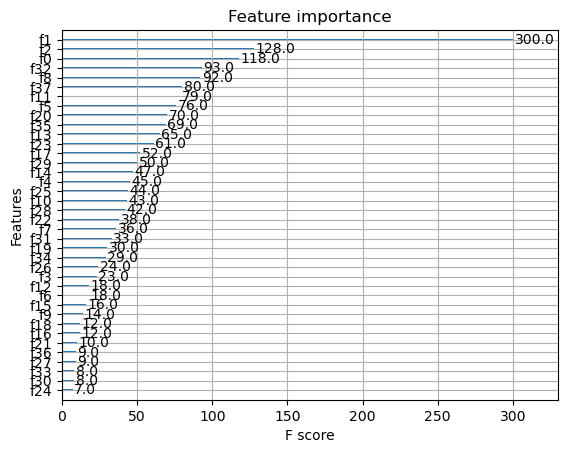

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

# 파일 경로
non_flood_data_path = '침수가아닌날데이터.csv'
flood_data_path = '침수학습데이터.csv'

# CSV 파일 불러오기
non_flood_data = pd.read_csv(non_flood_data_path)
flood_data = pd.read_csv(flood_data_path)

# 데이터에 타겟 변수 추가 (침수 여부: 0 - 침수가 아닌 날, 1 - 침수된 날)
non_flood_data['target'] = 0
flood_data['target'] = 1

# 두 데이터를 합침
combined_data = pd.concat([non_flood_data, flood_data], ignore_index=True)

# 사용할 칼럼만 선택
selected_columns = [
    '배수정보', '침수된 지역의 평균 지형 고도', '1시간 누적 강수량(mm)', '1시간 10분 평균 강수량(mm)', '1시간 시간당 강수량(mm)',
    '2시간 누적 강수량(mm)', '2시간 10분 평균 강수량(mm)', '2시간 시간당 강수량(mm)', '3시간 누적 강수량(mm)', '3시간 10분 평균 강수량(mm)',
    '3시간 시간당 강수량(mm)', '4시간 누적 강수량(mm)', '4시간 10분 평균 강수량(mm)', '4시간 시간당 강수량(mm)', '5시간 누적 강수량(mm)',
    '5시간 10분 평균 강수량(mm)', '5시간 시간당 강수량(mm)', '6시간 누적 강수량(mm)', '6시간 10분 평균 강수량(mm)', '6시간 시간당 강수량(mm)',
    '7시간 누적 강수량(mm)', '7시간 10분 평균 강수량(mm)', '7시간 시간당 강수량(mm)', '8시간 누적 강수량(mm)', '8시간 10분 평균 강수량(mm)',
    '8시간 시간당 강수량(mm)', '9시간 누적 강수량(mm)', '9시간 10분 평균 강수량(mm)', '9시간 시간당 강수량(mm)', '10시간 누적 강수량(mm)',
    '10시간 10분 평균 강수량(mm)', '10시간 시간당 강수량(mm)', '11시간 누적 강수량(mm)', '11시간 10분 평균 강수량(mm)', '11시간 시간당 강수량(mm)',
    '12시간 누적 강수량(mm)', '12시간 10분 평균 강수량(mm)', '12시간 시간당 강수량(mm)'
]

# 선택한 칼럼만 사용하여 데이터 준비
X = combined_data[selected_columns]
y = combined_data['target']

# 데이터 스케일링 (XGBoost는 스케일링이 필수는 아니지만, 다른 모델과 함께 사용할 경우 유용함)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 학습 데이터와 테스트 데이터로 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 하이퍼파라미터 설정
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0.1,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
    'eval_metric': 'logloss'  # 평가 지표로 로그 손실 사용
}

# XGBoost의 cv 메서드를 사용한 교차 검증
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=200,
    nfold=5,
    metrics={'logloss'},
    early_stopping_rounds=10,
    as_pandas=True,
    seed=42
)

# 최적의 부스팅 라운드 수 찾기
best_num_boost_rounds = cv_results['test-logloss-mean'].idxmin()

# 최적의 부스팅 라운드로 모델 학습
final_model = xgb.train(params, dtrain, num_boost_round=best_num_boost_rounds)

# 테스트 데이터에 대한 예측 및 평가
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# 피처 중요도 시각화
xgb.plot_importance(final_model)
plt.show()


In [8]:
# 사용할 칼럼만 선택
selected_columns = [
    '배수정보', '침수된 지역의 평균 지형 고도', '1시간 누적 강수량(mm)', '1시간 10분 평균 강수량(mm)', '1시간 시간당 강수량(mm)',
    '2시간 누적 강수량(mm)', '2시간 10분 평균 강수량(mm)', '2시간 시간당 강수량(mm)', '3시간 누적 강수량(mm)', '3시간 10분 평균 강수량(mm)',
    '3시간 시간당 강수량(mm)', '4시간 누적 강수량(mm)', '4시간 10분 평균 강수량(mm)', '4시간 시간당 강수량(mm)', '5시간 누적 강수량(mm)',
    '5시간 10분 평균 강수량(mm)', '5시간 시간당 강수량(mm)', '6시간 누적 강수량(mm)', '6시간 10분 평균 강수량(mm)', '6시간 시간당 강수량(mm)',
    '7시간 누적 강수량(mm)', '7시간 10분 평균 강수량(mm)', '7시간 시간당 강수량(mm)', '8시간 누적 강수량(mm)', '8시간 10분 평균 강수량(mm)',
    '8시간 시간당 강수량(mm)', '9시간 누적 강수량(mm)', '9시간 10분 평균 강수량(mm)', '9시간 시간당 강수량(mm)', '10시간 누적 강수량(mm)',
    '10시간 10분 평균 강수량(mm)', '10시간 시간당 강수량(mm)', '11시간 누적 강수량(mm)', '11시간 10분 평균 강수량(mm)', '11시간 시간당 강수량(mm)',
    '12시간 누적 강수량(mm)', '12시간 10분 평균 강수량(mm)', '12시간 시간당 강수량(mm)'
]
print(len(selected_columns))

38


스케일링된 데이터 (처음 5개의 샘플):
       배수정보  침수된 지역의 평균 지형 고도  1시간 누적 강수량(mm)  1시간 10분 평균 강수량(mm)  \
0 -0.056562          0.294559       -0.518944           -0.518944   
1 -0.103553         -0.098921       -0.518944           -0.518944   
2 -0.103553         -0.019792       -0.518944           -0.518944   
3 -0.103553         -0.101083       -0.518944           -0.518944   
4 -0.103553         -0.163780       -0.518944           -0.518944   

   1시간 시간당 강수량(mm)  2시간 누적 강수량(mm)  2시간 10분 평균 강수량(mm)  2시간 시간당 강수량(mm)  \
0        -0.523216       -0.627734           -0.627734        -0.633303   
1        -0.523216       -0.627734           -0.627734        -0.633303   
2        -0.523216       -0.627734           -0.627734        -0.633303   
3        -0.523216       -0.627734           -0.627734        -0.633303   
4        -0.523216       -0.627734           -0.627734        -0.633303   

   3시간 누적 강수량(mm)  3시간 10분 평균 강수량(mm)  ...  9시간 시간당 강수량(mm)  10시간 누적 강수량(mm)  \
0       -0.667408           -0.

NameError: name 'plt' is not defined

c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  func(*args, **kwargs)
c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  func(*args, **kwargs)
c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from current font.
  func(*args, **kwargs)
c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from current font.
  func(*args, **kwargs)
c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from current font.
  func(*args, **kwargs)
c:\Users\kally\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 44053 (\N{HANGUL SYLLABLE GANG}) missing from cu

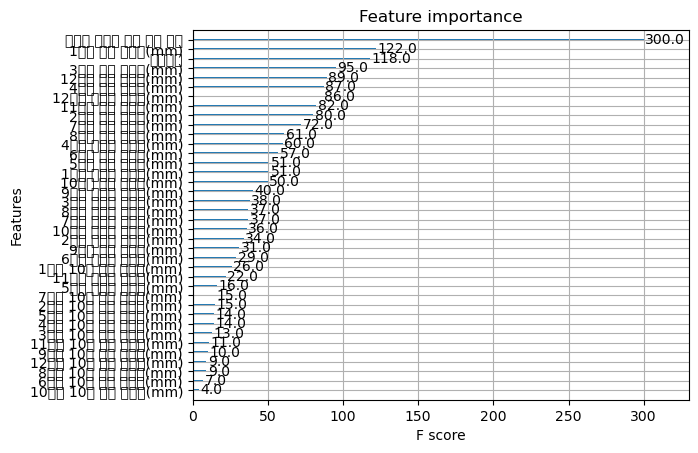

In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb

# 데이터 로드 및 전처리
non_flood_data_path = '침수가아닌날데이터.csv'
flood_data_path = '침수학습데이터.csv'

# CSV 파일 불러오기
non_flood_data = pd.read_csv(non_flood_data_path)
flood_data = pd.read_csv(flood_data_path)

# 데이터에 타겟 변수 추가 (침수 여부: 0 - 침수가 아닌 날, 1 - 침수된 날)
non_flood_data['target'] = 0
flood_data['target'] = 1

# 두 데이터를 합침
combined_data = pd.concat([non_flood_data, flood_data], ignore_index=True)

# 사용할 칼럼만 선택
selected_columns = [
    '배수정보', '침수된 지역의 평균 지형 고도', '1시간 누적 강수량(mm)', '1시간 10분 평균 강수량(mm)', '1시간 시간당 강수량(mm)',
    '2시간 누적 강수량(mm)', '2시간 10분 평균 강수량(mm)', '2시간 시간당 강수량(mm)', '3시간 누적 강수량(mm)', '3시간 10분 평균 강수량(mm)',
    '3시간 시간당 강수량(mm)', '4시간 누적 강수량(mm)', '4시간 10분 평균 강수량(mm)', '4시간 시간당 강수량(mm)', '5시간 누적 강수량(mm)',
    '5시간 10분 평균 강수량(mm)', '5시간 시간당 강수량(mm)', '6시간 누적 강수량(mm)', '6시간 10분 평균 강수량(mm)', '6시간 시간당 강수량(mm)',
    '7시간 누적 강수량(mm)', '7시간 10분 평균 강수량(mm)', '7시간 시간당 강수량(mm)', '8시간 누적 강수량(mm)', '8시간 10분 평균 강수량(mm)',
    '8시간 시간당 강수량(mm)', '9시간 누적 강수량(mm)', '9시간 10분 평균 강수량(mm)', '9시간 시간당 강수량(mm)', '10시간 누적 강수량(mm)',
    '10시간 10분 평균 강수량(mm)', '10시간 시간당 강수량(mm)', '11시간 누적 강수량(mm)', '11시간 10분 평균 강수량(mm)', '11시간 시간당 강수량(mm)',
    '12시간 누적 강수량(mm)', '12시간 10분 평균 강수량(mm)', '12시간 시간당 강수량(mm)'
]

# 선택한 칼럼만 사용하여 데이터 준비
X = combined_data[selected_columns]
y = combined_data['target']

# 데이터 스케일링 (StandardScaler 또는 MinMaxScaler 사용 가능)
scaler = StandardScaler()
# scaler = MinMaxScaler()  # 사용하려면 이 줄로 대체
X_scaled = scaler.fit_transform(X)

# 스케일링된 데이터 확인 (처음 5개의 샘플 출력)
scaled_df = pd.DataFrame(X_scaled, columns=selected_columns)
print("스케일링된 데이터 (처음 5개의 샘플):")
print(scaled_df.head())

# 학습 데이터와 테스트 데이터로 분리 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# XGBoost DMatrix 생성
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# 하이퍼파라미터 설정
params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eval_metric': 'logloss'
}

# XGBoost의 cv 메서드를 사용한 교차 검증
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=200,
    nfold=5,
    metrics={'logloss'},
    early_stopping_rounds=10,
    as_pandas=True,
    seed=42
)

# 최적의 부스팅 라운드 수 찾기
best_num_boost_rounds = cv_results['test-logloss-mean'].idxmin()

# 최적의 부스팅 라운드로 모델 학습
final_model = xgb.train(params, dtrain, num_boost_round=best_num_boost_rounds)

# 테스트 데이터에 대한 예측 및 평가
y_pred = final_model.predict(dtest)
y_pred_binary = [1 if x > 0.5 else 0 for x in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
report = classification_report(y_test, y_pred_binary)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{report}')

# 피처 중요도 시각화
xgb.plot_importance(final_model)
plt.show()

